### 3. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений.

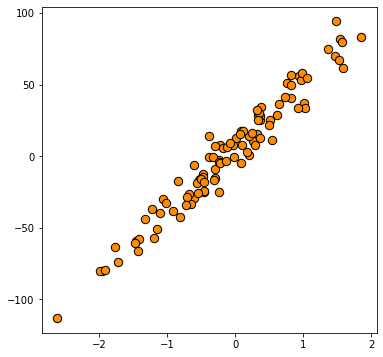

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, bias=5, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [2]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return self.labels.mean()      

In [5]:
# Расчет качества

def quality(left_labels, right_labels, current_dispersion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * left_labels.var() - (1 - p) * right_labels.var()

In [6]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [7]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_dispersion = labels.var()

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [8]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [9]:
def definite_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return definite_object(obj, node.true_branch)
    else:
        return definite_object(obj, node.false_branch)

In [14]:
def predict(data, tree):
    
    targets = []
    for obj in data:
        prediction = definite_object(obj, tree)
        targets.append(prediction)
    return targets

In [15]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.08704706823817121
--> True:
  Индекс 0
  Порог -1.1509935774223028
  --> True:
    Индекс 0
    Порог -1.4785219903674274
    --> True:
      Прогноз: -74.83830483283232
    --> False:
      Прогноз: -55.95922383468576
  --> False:
    Индекс 0
    Порог -0.46341769281246226
    --> True:
      Индекс 0
      Порог -0.6017066122293969
      --> True:
        Прогноз: -31.059947905776482
      --> False:
        Прогноз: -17.82218541713025
    --> False:
      Индекс 0
      Порог -0.22577630048653566
      --> True:
        Прогноз: -2.073890167233853
      --> False:
        Прогноз: 2.8772350966915217
--> False:
  Индекс 0
  Порог 1.030999522495951
  --> True:
    Индекс 0
    Порог 0.6116762888408679
    --> True:
      Индекс 0
      Порог 0.3142473325952739
      --> True:
        Прогноз: 14.177472417443052
      --> False:
        Прогноз: 24.13999224264635
    --> False:
      Прогноз: 43.173811718316166
  --> False:
    Прогноз: 76.44432708402037


In [17]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [18]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [24]:
# качество модели будем определять по метрике R2
def r2_score(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    return 1 - np.sum((y - y_hat)**2)/np.sum((y - y.mean())**2)

In [25]:
r2_score(train_labels, train_answers)

0.9690088203972537

In [26]:
r2_score(test_labels, answers)

0.8845321472595797

### Проверим модель на аналоге из sklearn

In [43]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
reg.fit(train_data, train_labels)

RandomForestRegressor(bootstrap=False, min_samples_leaf=5, n_estimators=1)

In [44]:
preds = reg.predict(test_data)
r2_score(test_labels, preds)

0.8940961381582964

In [45]:
preds

array([-74.83830483,  43.17381172, -17.82218542,  14.17747242,
       -17.82218542,  24.13999224,  -2.07389017,  14.17747242,
        43.17381172,  43.17381172,   2.8772351 ,  -2.07389017,
        24.13999224,  -2.07389017,   2.8772351 ,  14.17747242,
        24.13999224,  -2.07389017,  14.17747242,  43.17381172,
       -31.05994791, -55.95922383, -31.05994791, -55.95922383,
       -74.83830483,  14.17747242, -17.82218542,   2.8772351 ,
        -2.07389017,  43.17381172])

In [46]:
np.array(answers)

array([-74.83830483,  76.44432708, -17.82218542,  14.17747242,
       -17.82218542,  24.13999224,  -2.07389017,  14.17747242,
        43.17381172,  43.17381172,   2.8772351 ,  -2.07389017,
        24.13999224,  -2.07389017,   2.8772351 ,  14.17747242,
        24.13999224,  -2.07389017,  14.17747242,  43.17381172,
       -31.05994791, -55.95922383, -31.05994791, -31.05994791,
       -74.83830483,  14.17747242,  -2.07389017,   2.8772351 ,
        -2.07389017,  43.17381172])

Некоторые предсказания отличаются, при этом у стандартной библиотеки они немного точнее.

Text(0.5, 1.0, 'Custom decision tree regressor, R2 = 0.8845')

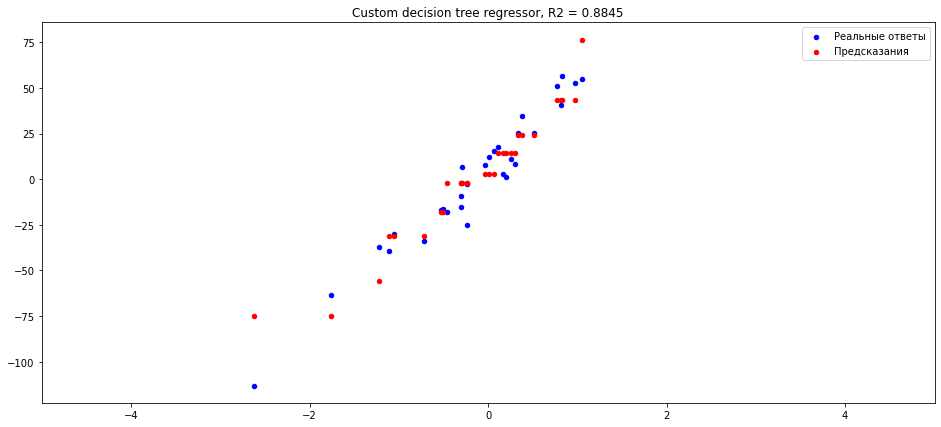

In [58]:
plt.figure(figsize = (16, 7))

plt.scatter(test_data, test_labels, c="b", s=20, label='Реальные ответы')
plt.scatter(test_data, answers, c="r", s=20, label='Предсказания')
plt.xlim([-5, 5])
plt.legend()
plt.title("Custom decision tree regressor, R2 = %.4f" % r2_score(test_labels, answers))

Text(0.5, 1.0, 'Sklearn decision tree regressor, R2 = 0.8941')

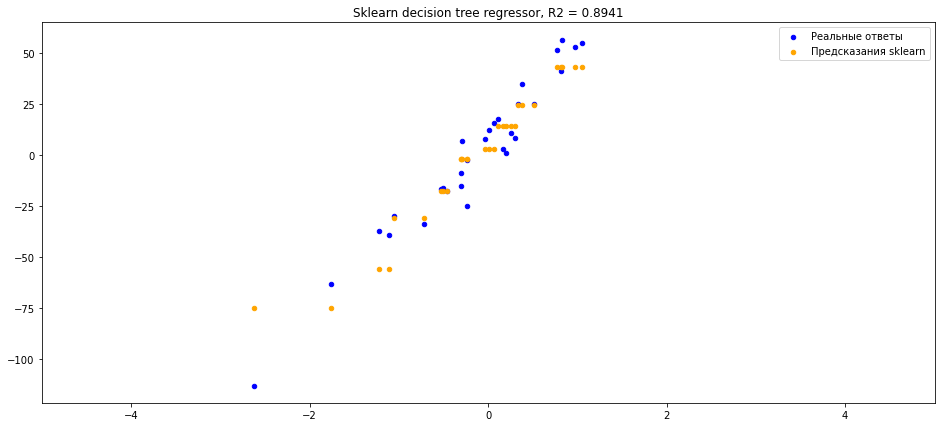

In [59]:
plt.figure(figsize = (16, 7))

plt.scatter(test_data, test_labels, c="b", s=20, label='Реальные ответы')
plt.scatter(test_data, preds, c="orange", s=20, label='Предсказания sklearn')
plt.xlim([-5, 5])
plt.legend()
plt.title("Sklearn decision tree regressor, R2 = %.4f" % r2_score(test_labels, preds))